In [3]:
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import expr
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from helpers.helper_functions import translate_to_file_string
from pyspark.sql import DataFrameReader
from pyspark.sql import SparkSession
from pyspark.ml.feature import IndexToString, Normalizer, StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from helpers.helper_functions import translate_to_file_string
from sklearn.metrics import roc_curve, auc
from sklearn.tree import plot_tree
import seaborn as sns
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
# for pretty printing
def printDf(sprkDF): 
    newdf = sprkDF.toPandas()
    from IPython.display import display, HTML
    return HTML(newdf.to_html())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [4]:
inputFile = translate_to_file_string("../data/heart_val.csv")

In [5]:
spark = (SparkSession
       .builder
       .appName("HeartDiseaseAnalDT")
       .getOrCreate())

In [6]:
# load data file.
# create a DataFrame using an ifered Schema 
df = spark.read.option("header", "true") \
       .option("inferSchema", "true") \
       .option("delimiter", ";") \
       .csv(inputFile)
print(df.printSchema())

#Pandas df for visualization
dfp = df.toPandas()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: string (nullable = true)

None


In [7]:
# Show summary of data
printDf(df.summary())

,summary,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,count,303,303,303,303,303,303,303,303,303,303,303,303,303,303
1,mean,54.366336633663366,None,0.966996699669967,131.62376237623764,246.26402640264027,0.1485148514851485,0.528052805280528,149.64686468646866,0.32673267326732675,1.0396039603960396,1.3993399339933994,0.7293729372937293,2.3135313531353137,None
2,stddev,9.08210098983786,None,1.0320524894832983,17.5381428135171,51.83075098793005,0.35619787492797644,0.525859596359298,22.90516111491409,0.46979446452231655,1.1610750220686346,0.6162261453459622,1.0226063649693276,0.6122765072781408,None
3,min,29,f,0,94,126,0,0,71,0,0.0,0,0,0,n
4,25%,47,None,0,120,211,0,0,133,0,0.0,1,0,2,None
5,50%,55,None,1,130,240,0,1,153,0,0.8,1,0,2,None
6,75%,61,None,2,140,275,0,1,166,1,1.6,2,1,3,None
7,max,77,m,3,200,564,1,2,202,1,6.2,2,4,3,y


In [8]:
age_groups = pd.cut(dfp['age'], bins=[20, 30,40,50,60,70,80,90])
pd.crosstab(age_groups, dfp['sex'])

sex,f,m
age,,
"(20, 30]",0,1
"(30, 40]",5,13
"(40, 50]",22,54
"(50, 60]",35,94
"(60, 70]",29,44
"(70, 80]",5,1


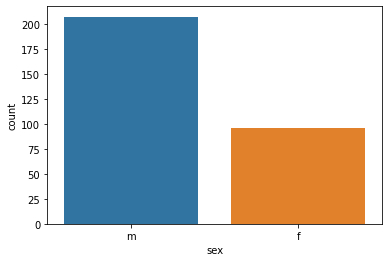

In [9]:
dfp.sex.value_counts()
#Sex (1 = male; 0 = female)
sns.countplot(dfp.sex)
plt.show()

Saving figure attribute_box_plots


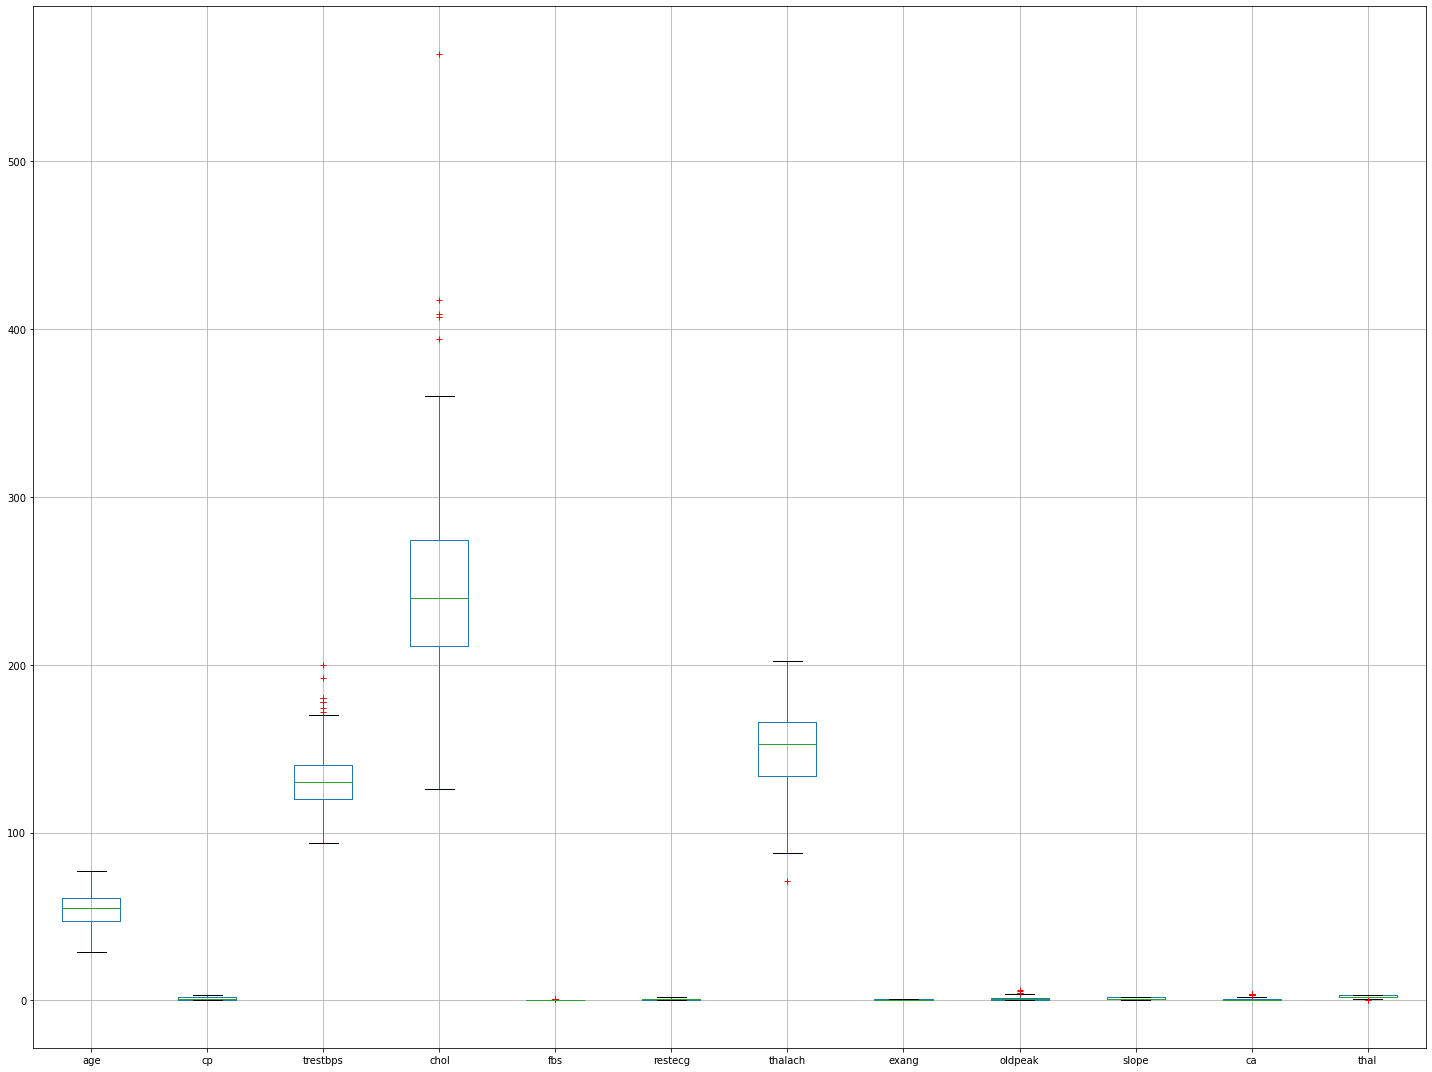

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
df.toPandas().boxplot(sym='r+', figsize=(20,15))
save_fig("attribute_box_plots")
plt.show()

Saving figure attribute_density_plots


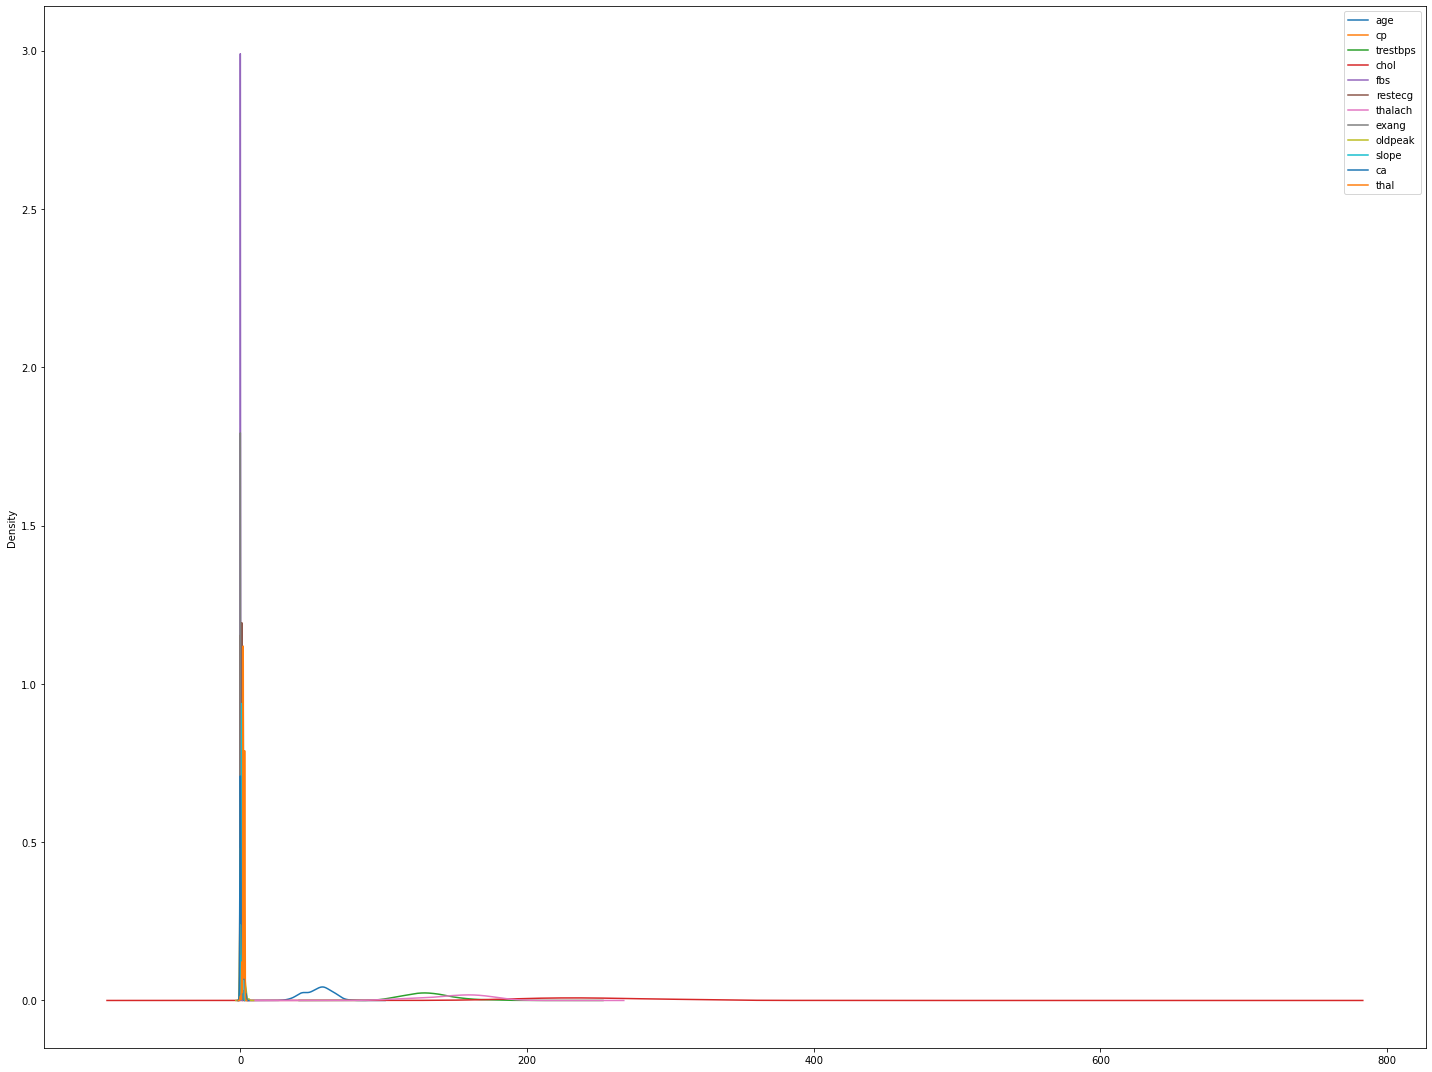

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
df.toPandas().plot.kde(figsize=(20,15))
save_fig("attribute_density_plots")
plt.show()

Saving figure attribute_histogram_plots


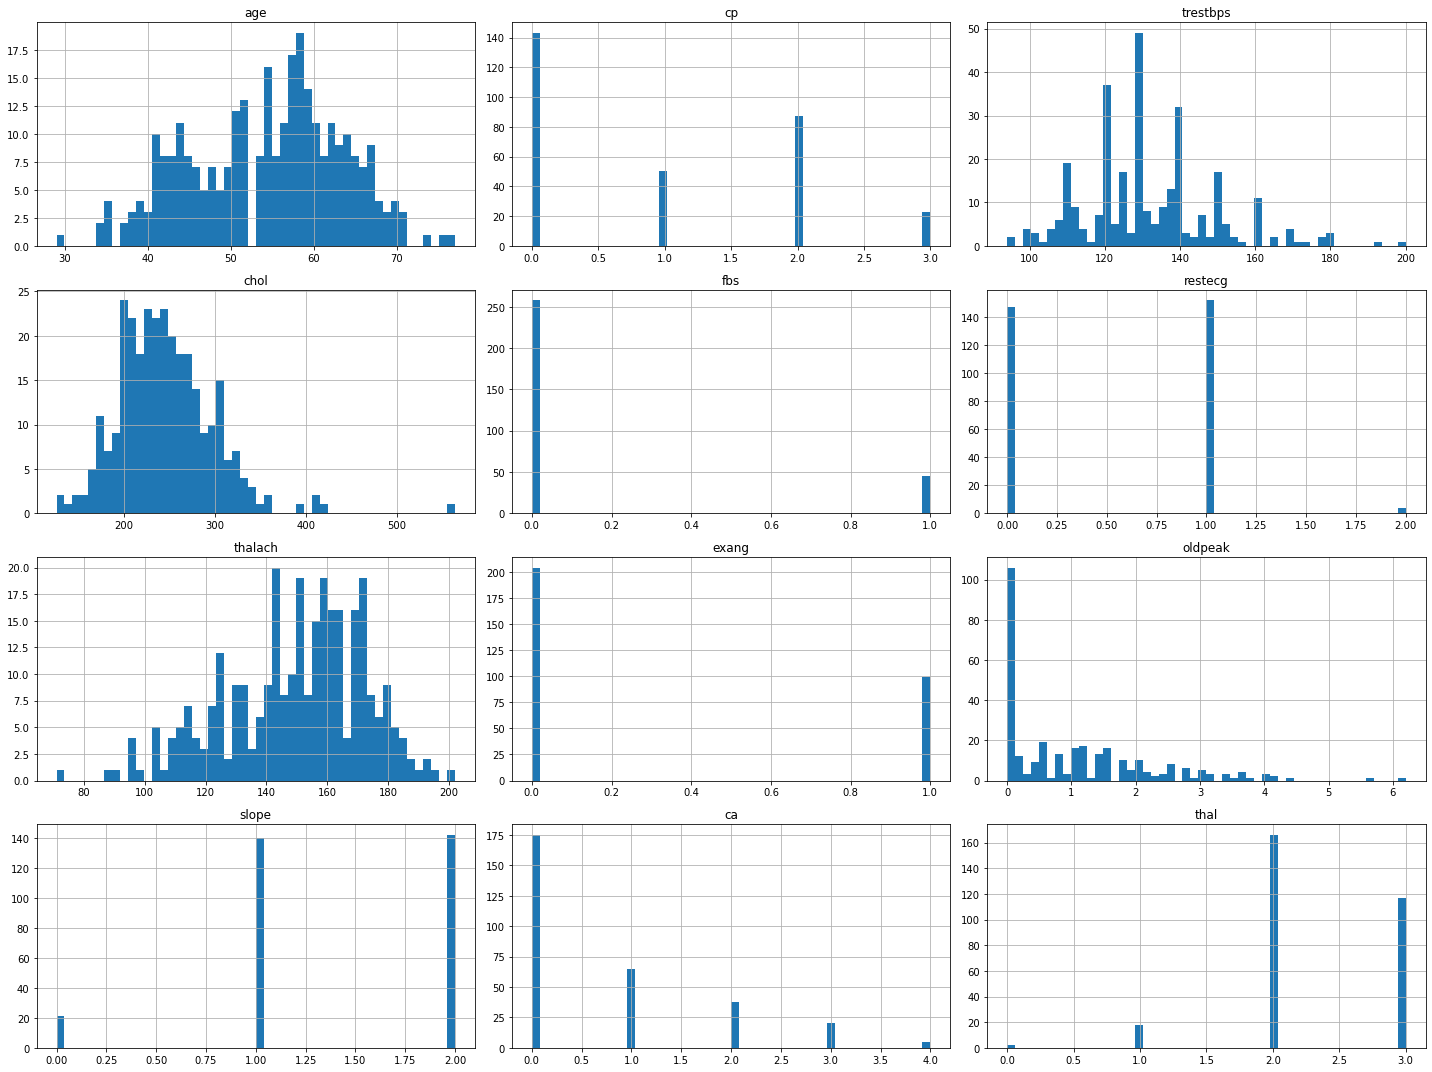

In [12]:
dfp.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [13]:
#transform labels
labelIndexer = StringIndexer().setInputCol("target").setOutputCol("label").fit(df)
sexIndexer = StringIndexer().setInputCol("sex").setOutputCol("sex_num").fit(df)

In [14]:
#feature cols- die spalten die interessieren, auch gerne entfernen für tests
featureCols = df.columns.copy()
featureCols.remove("target")
featureCols.remove("sex")
featureCols = featureCols + ["sex_num"]

In [15]:
#vektor assembler
assembler =  VectorAssembler(outputCol="features", inputCols=list(featureCols))

In [16]:
#Build feauture Indexer 
featureIndexer = VectorIndexer(inputCol="features",outputCol="indexedFeatures", maxCategories=6)

In [17]:
#Convert Indexed labels back to original labels
  = IndexToString(inputCol="prediction",outputCol="predictedLabel",labels=labelIndexer.labels)

In [18]:
#Build decistion tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [19]:
# build a network para grip
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [ 5, 10 ]) \
				              .addGrid(dt.minInfoGain, [0.05, 0.025, 0.02, 0.01]) \
				              .addGrid(dt.minInstancesPerNode, [5, 10, 15]) \
                              .addGrid(dt.maxBins, [5, 6, 9]) \
				              .build()

In [20]:
#split data for etsting

splits = df.randomSplit([0.8, 0.2 ], 1234)
train = splits[0]
test = splits[1]

In [21]:
#Pipelining of all steps 
pipeline = Pipeline(stages= [labelIndexer,sexIndexer,  assembler, featureIndexer,   dt, predConverter])

In [22]:
#build evaluator 


In [23]:
evaluator =  BinaryClassificationEvaluator(labelCol="label",rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [24]:
#Cross validator
cv = CrossValidator(estimator=pipeline, evaluator=evaluator,estimatorParamMaps=paramGrid,numFolds=10, parallelism=2)

In [25]:
#train modle
cvModel = cv.fit(train)

In [26]:
#Find out the best model
treeModel = cvModel.bestModel.stages[4] #.extractParamMap()
print("Learned classification tree model:\n",treeModel)
print("Best Params: \n", treeModel.explainParams())

Learned classification tree model:
 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_64606a207b26, depth=4, numNodes=17, numClasses=2, numFeatures=13
Best Params: 
 cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default

In [32]:
#show tree
#plt.figure(figsize=(35,28))

classes = ["No Disease","Diasease"]
plot_tree(treeModel)
#plot_tree(treeModel,feature_names=dfp.columns,class_names=classes,filled=True,rounded=True)

TypeError: DecisionTreeClassificationModel: uid=DecisionTreeClassifier_64606a207b26, depth=4, numNodes=17, numClasses=2, numFeatures=13 is not an estimator instance.

In [ ]:
#test model
predictions = cvModel.transform(test)
predictions.select("prediction", "label", "target", "features").show()

In [ ]:
accuracy = evaluator.evaluate(predictions)
print("Test Error = " ,(1.0 - accuracy))

In [ ]:
spark.stop()